# Home assignment

* Author: Romain Tavenard (@rtavenar)
* License: CC-BY-NC-SA

A home assignment from a course on Machine Learning for Time Series at ENSAI.
One can find lecture notes for this course [there](https://rtavenar.github.io/ml4ts_ensai/).

## Problem statement

The dataset we are interested in here is called "TwoPatterns". It is described [in this page](http://www.timeseriesclassification.com/description.php?Dataset=TwoPatterns) and can be downloaded using `tslearn`'s `load_dataset` utility, as seen in previous labs.

You should load the data and analyze it under several angles:

1. visualize the dataset (or a few time series from the dataset) to understand whether you expect time-shift-invariant methods to perform well on this dataset or not ;
2. compare time-shift-invariant methods to their time-shift-sensitive counterparts for the following tasks, and conclude:
    * clustering ;
    * supervised classification ;
    * forecasting (suppose you have to forecast the second half of the series with the first half provided as input).

It is not asked here that you implement specific layers / methods by yourself, but rather that you use established implementations of the methods you need.
Your focus should rather be on:
* data visualization, 
* model architecture (for deep networks),
* experiment design,
* result analysis

## This document

The following gives ideas about ways this assignment could have been tackled.

## Data loading and visualization

In [1]:
from tslearn.datasets import UCR_UEA_datasets

data_loader = UCR_UEA_datasets()

X_train, y_train, X_test, y_test = data_loader.load_dataset("TwoPatterns")

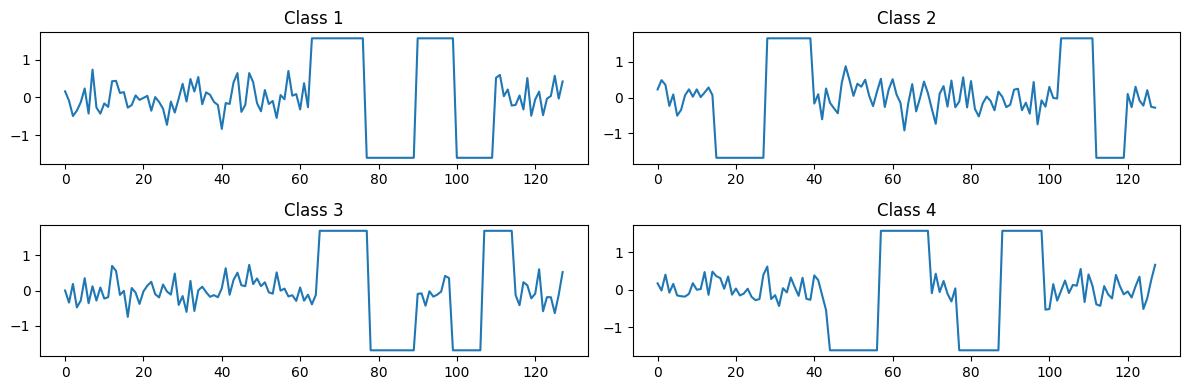

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
for yi in set(y_train):
    plt.subplot(2, 2, yi)
    plt.plot(X_train[y_train == yi][0])
    plt.title(f"Class {yi}")
plt.tight_layout();

One can see here that these time series are mostly made of white noise and only two distinct patterns are present - located at random in the time series.

These patterns are either in the form "down-up" or "up-down", and each class has a different combination:
* Class 1 is "up-down" followed by "up-down" ;
* Class 2 is "down-up" followed by "up-down" ;
* Class 3 is "up-down" followed by "down-up" ;
* Class 4 is "up-down" followed by "up-down".

As stated previously, exact localization of these patterns in the series is non important but their respective order of appearance has impact on the class label.

## Clustering

Let's use $k$-means clustering with different metrics to extract groups from this dataset.

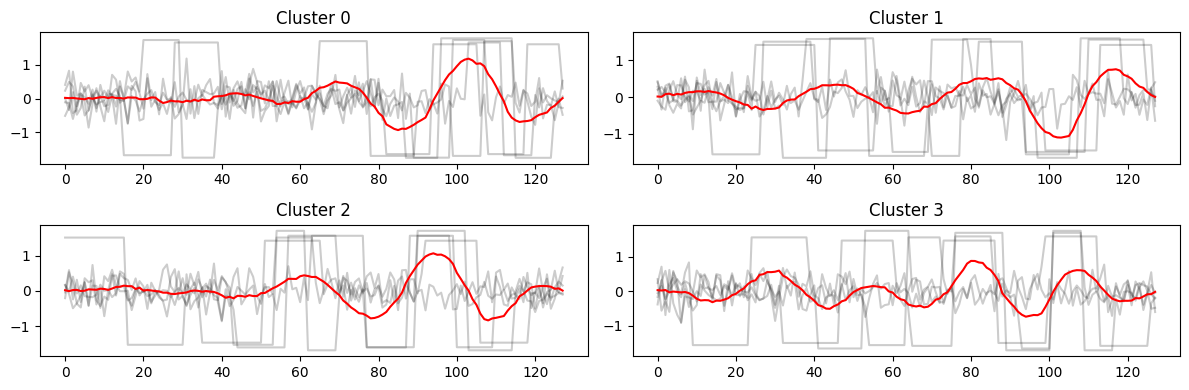

In [3]:
from tslearn.clustering import TimeSeriesKMeans

km_euc = TimeSeriesKMeans(n_clusters=4, max_iter=10, metric="euclidean")
km_euc.fit(X_train)

plt.figure(figsize=(12, 4))
for yi in range(4):
    plt.subplot(2, 2, yi + 1)
    for Xi in X_train[km_euc.labels_ == yi][:5]:
        plt.plot(Xi, color="k", alpha=.2)
    plt.plot(km_euc.cluster_centers_[yi], color="r")
    plt.title(f"Cluster {yi}")
plt.tight_layout();

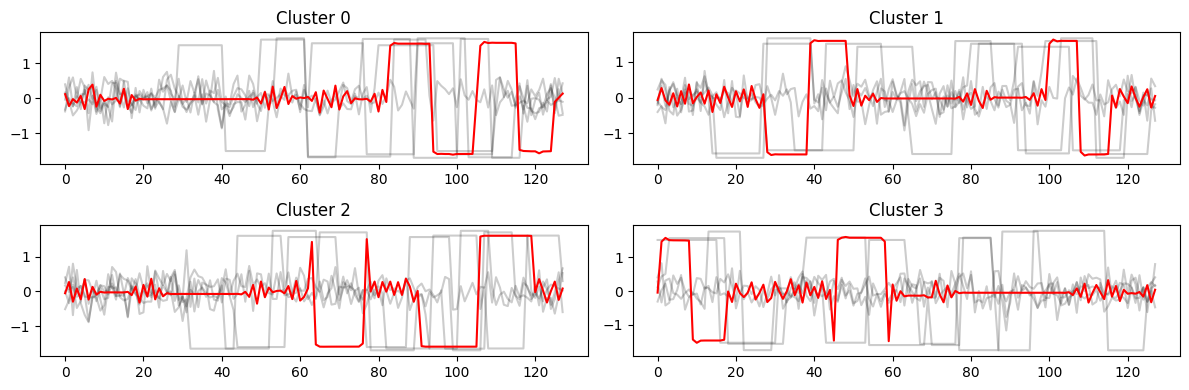

In [4]:
from tslearn.clustering import TimeSeriesKMeans

km_dtw = TimeSeriesKMeans(n_clusters=4, max_iter=10, metric="dtw")
km_dtw.fit(X_train)

plt.figure(figsize=(12, 4))
for yi in range(4):
    plt.subplot(2, 2, yi + 1)
    for Xi in X_train[km_dtw.labels_ == yi][:5]:
        plt.plot(Xi, color="k", alpha=.2)
    plt.plot(km_dtw.cluster_centers_[yi], color="r")
    plt.title(f"Cluster {yi}")
plt.tight_layout();

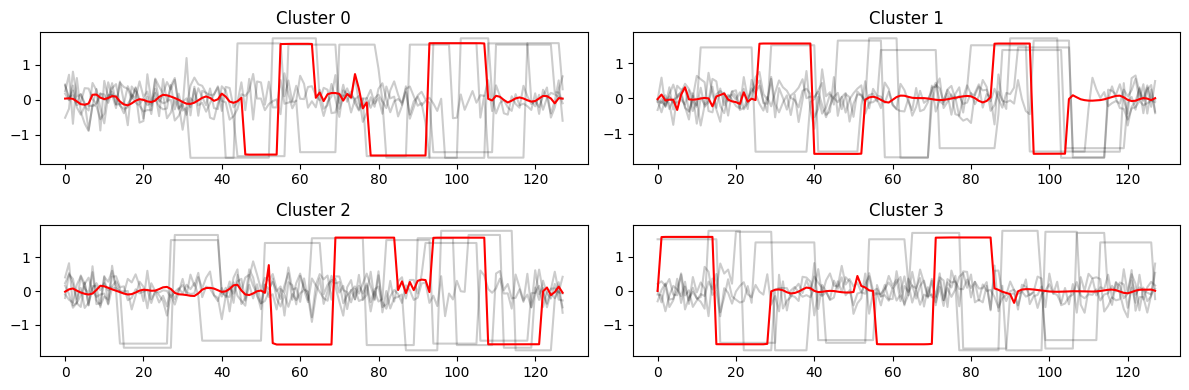

In [5]:
from tslearn.clustering import TimeSeriesKMeans

km_sdtw = TimeSeriesKMeans(n_clusters=4, max_iter=10, metric="softdtw", metric_params={"gamma": .1})
km_sdtw.fit(X_train)

plt.figure(figsize=(12, 4))
for yi in range(4):
    plt.subplot(2, 2, yi + 1)
    for Xi in X_train[km_sdtw.labels_ == yi][:5]:
        plt.plot(Xi, color="k", alpha=.2)
    plt.plot(km_sdtw.cluster_centers_[yi], color="r")
    plt.title(f"Cluster {yi}")
plt.tight_layout();

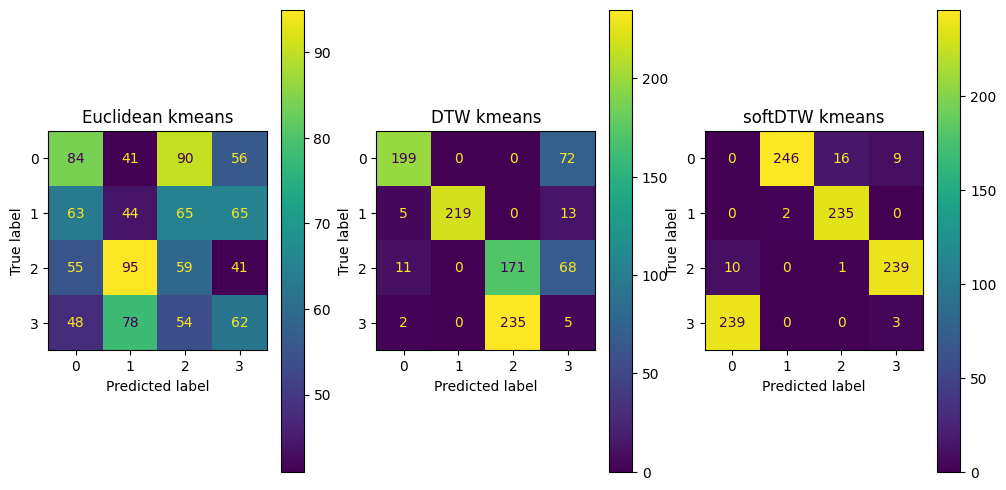

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
cm = confusion_matrix(y_train, km_euc.labels_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm[1:, :-1])
disp.plot(ax=plt.gca())
plt.title("Euclidean kmeans")

plt.subplot(1, 3, 2)
cm = confusion_matrix(y_train, km_dtw.labels_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm[1:, :-1])
disp.plot(ax=plt.gca())
plt.title("DTW kmeans")

plt.subplot(1, 3, 3)
cm = confusion_matrix(y_train, km_sdtw.labels_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm[1:, :-1])
disp.plot(ax=plt.gca())
plt.title("softDTW kmeans");

Here we see that, as expected, confusion matrices are much sharper for (soft-)DTW than for Euclidean distance.

## Supervised classification


In [7]:
import os
os.environ["KERAS_BACKEND"] = "torch"  # Use torch as keras backend to enable softDTW loss later

from keras.models import Sequential
from keras.layers import InputLayer, Conv1D, GlobalMaxPooling1D, Dense, Flatten, LSTM, Reshape
from keras.utils import to_categorical

y_train_cat = to_categorical(y_train - 1)
y_test_cat = to_categorical(y_test - 1)

m_conv1 = Sequential([
    InputLayer(shape=(128, 1)),
    Conv1D(filters=128, kernel_size=5, activation="relu"),
    Conv1D(filters=128, kernel_size=5, activation="relu"),
    Conv1D(filters=128, kernel_size=5, activation="relu"),
    GlobalMaxPooling1D(),  # Does pooling over the whole temporal dimension
    Dense(units=4, activation="softmax")
])
m_conv1.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
h_conv1 = m_conv1.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), epochs=20, batch_size=64)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 920ms/step - accuracy: 0.4812 - loss: 1.2342 - val_accuracy: 0.7358 - val_loss: 0.8138
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 917ms/step - accuracy: 0.7470 - loss: 0.7000 - val_accuracy: 0.7567 - val_loss: 0.4918
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 926ms/step - accuracy: 0.7499 - loss: 0.4809 - val_accuracy: 0.7470 - val_loss: 0.4428
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 882ms/step - accuracy: 0.7734 - loss: 0.4019 - val_accuracy: 0.7415 - val_loss: 0.4550
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 860ms/step - accuracy: 0.7667 - loss: 0.4242 - val_accuracy: 0.7862 - val_loss: 0.3840
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 859ms/step - accuracy: 0.8075 - loss: 0.3732 - val_accuracy: 0.7607 - val_loss: 0.4382
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 860ms/step - accuracy: 0.8075 - loss: 0.3576 - val_accuracy: 0.8018 - val_loss: 0.3643
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 860ms/step - accuracy: 0.8285 - loss: 0.3364 - val_accu

In [8]:
m_conv2 = Sequential([
    InputLayer(shape=(128, 1)),
    Conv1D(filters=128, kernel_size=5, activation="relu"),
    Conv1D(filters=128, kernel_size=5, activation="relu"),
    Conv1D(filters=128, kernel_size=5, activation="relu"),
    Flatten(),  # Flattens instead of pooling (hence keep temporal ordering)
    Dense(units=4, activation="softmax")
])
m_conv2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
h_conv2 = m_conv2.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), epochs=20, batch_size=64)

Epoch 1/20


16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 863ms/step - accuracy: 0.3331 - loss: 1.3059 - val_accuracy: 0.5885 - val_loss: 0.9414
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 863ms/step - accuracy: 0.6456 - loss: 0.7999 - val_accuracy: 0.7595 - val_loss: 0.5885
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 862ms/step - accuracy: 0.8287 - loss: 0.4532 - val_accuracy: 0.8100 - val_loss: 0.4633
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 865ms/step - accuracy: 0.9346 - loss: 0.2283 - val_accuracy: 0.9528 - val_loss: 0.1685
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 865ms/step - accuracy: 0.9822 - loss: 0.0772 - val_accuracy: 0.9800 - val_loss: 0.0770
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 867ms/step - accuracy: 0.9984 - loss: 0.0175 - val_accuracy: 0.9877 - val_loss: 0.0484
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 861ms/step - accuracy: 1.0000 - loss: 0.0062 - val_accuracy: 0.9883 - val_loss: 0.0451
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 865ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 0.985

In [9]:
m_lstm1 = Sequential([
    InputLayer(shape=(128, 1)),
    LSTM(units=128, return_sequences=True),
    LSTM(units=128, return_sequences=True),
    LSTM(units=128, return_sequences=False),
    Flatten(),
    Dense(units=4, activation="softmax")
])
m_lstm1.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
h_lstm1 = m_lstm1.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), epochs=20, batch_size=64)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 844ms/step - accuracy: 0.4313 - loss: 1.2299 - val_accuracy: 0.5102 - val_loss: 0.8648
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 821ms/step - accuracy: 0.5272 - loss: 0.7940 - val_accuracy: 0.6720 - val_loss: 0.6174
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 824ms/step - accuracy: 0.7215 - loss: 0.5602 - val_accuracy: 0.5595 - val_loss: 1.0651
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 819ms/step - accuracy: 0.6379 - loss: 0.7110 - val_accuracy: 0.8190 - val_loss: 0.4665
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 806ms/step - accuracy: 0.8426 - loss: 0.3827 - val_accuracy: 0.9690 - val_loss: 0.1703
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 790ms/step - accuracy: 0.8776 - loss: 0.3854 - val_accuracy: 0.7327 - val_loss: 0.5161
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 784ms/step - accuracy: 0.7213 - loss: 0.4932 - val_accuracy: 0.6140 - val_loss: 1.1653
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 814ms/step - accuracy: 0.6878 - loss: 0.8591 - val_accu

In [10]:
m_lstm2 = Sequential([
    InputLayer(shape=(128, 1)),
    LSTM(units=128, return_sequences=True),
    LSTM(units=128, return_sequences=True),
    LSTM(units=128, return_sequences=True),
    Flatten(),
    Dense(units=4, activation="softmax")
])
m_lstm2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
h_lstm2 = m_lstm2.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), epochs=20, batch_size=64)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 785ms/step - accuracy: 0.4730 - loss: 1.1578 - val_accuracy: 0.7207 - val_loss: 0.6802
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 803ms/step - accuracy: 0.7460 - loss: 0.5988 - val_accuracy: 0.8015 - val_loss: 0.5010
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 822ms/step - accuracy: 0.8548 - loss: 0.3640 - val_accuracy: 0.8407 - val_loss: 0.3904
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 813ms/step - accuracy: 0.9149 - loss: 0.1887 - val_accuracy: 0.9360 - val_loss: 0.1675
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 813ms/step - accuracy: 0.9743 - loss: 0.0675 - val_accuracy: 0.9617 - val_loss: 0.1639
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 821ms/step - accuracy: 0.9675 - loss: 0.0847 - val_accuracy: 0.9852 - val_loss: 0.0402
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 821ms/step - accuracy: 0.9922 - loss: 0.0245 - val_accuracy: 0.9900 - val_loss: 0.0354
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 849ms/step - accuracy: 0.9954 - loss: 0.0143 - val_accu

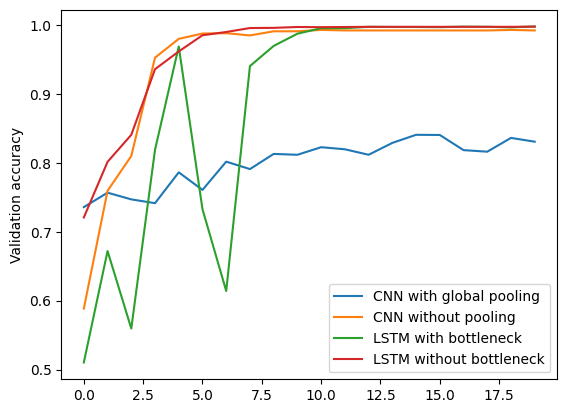

In [11]:
for hist, model_name in zip([h_conv1, h_conv2, h_lstm1, h_lstm2],
                            ["CNN with global pooling", "CNN without pooling", 
                             "LSTM with bottleneck", "LSTM without bottleneck"]):
    plt.plot(hist.history["val_accuracy"], label=model_name)
plt.ylabel("Validation accuracy")
plt.legend();

We observe that the only model that struggles with this problem is the CNN with global pooling since with this model the ordering of the patterns is lost. Other models perform well, even if the LSTM with bottleneck (for which the last LSTM layer does not return the full sequence but only the last element) is less stable during training.

## Forecasting



In [12]:
X_train_past = X_train[:, :64]
X_train_future = X_train[:, 64:]
X_test_past = X_test[:, :64]
X_test_future = X_test[:, 64:]

model_mse = Sequential([
    InputLayer(shape=(64, 1)),
    LSTM(units=128, return_sequences=True),
    LSTM(units=128, return_sequences=True),
    LSTM(units=128, return_sequences=True),
    Flatten(),
    Dense(units=64),
    Reshape(target_shape=(64, 1))
])
model_mse.compile(optimizer="adam", loss="mse")
h_mse = model_mse.fit(X_train_past, X_train_future, validation_data=(X_test_past, X_test_future), epochs=50, batch_size=64)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 405ms/step - loss: 1.2218 - val_loss: 1.1978
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 451ms/step - loss: 1.2060 - val_loss: 1.1790
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 426ms/step - loss: 1.1758 - val_loss: 1.1691
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 438ms/step - loss: 1.1570 - val_loss: 1.1676
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 441ms/step - loss: 1.1333 - val_loss: 1.1559
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 459ms/step - loss: 1.1261 - val_loss: 1.1488
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 420ms/step - loss: 1.1166 - val_loss: 1.1466
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 421ms/step - loss: 1.1202 - val_loss: 1.1451
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 437ms/step - loss: 1.1040 - val_loss: 1.1454
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 437ms/step - loss: 1.1017 - val_loss: 1.1437
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 414ms/step - loss: 1.0898 - val_loss: 1.1422
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 437ms/step

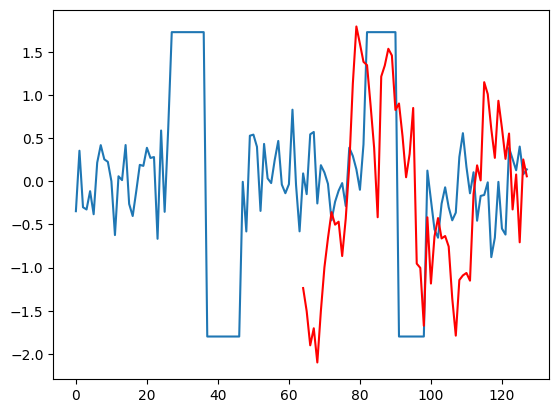

In [13]:
import numpy as np
ts_index = 50

y_pred = model_mse(X_test_past).detach().numpy()

plt.figure()
plt.plot(X_test[ts_index])
plt.plot(np.arange(64, 128), y_pred[ts_index], 'r-')
plt.show()

In [14]:
from tslearn.metrics import SoftDTWLossPyTorch

model_sdtw = Sequential([
    InputLayer(shape=(64, 1)),
    LSTM(units=128, return_sequences=True),
    LSTM(units=128, return_sequences=True),
    LSTM(units=128, return_sequences=True),
    Flatten(),
    Dense(units=64),
    Reshape(target_shape=(64, 1))
])
model_sdtw.compile(optimizer="adam", loss=SoftDTWLossPyTorch(gamma=.1, normalize=True))
h_sdtw = model_sdtw.fit(X_train_past, X_train_future, validation_data=(X_test_past, X_test_future), epochs=50, batch_size=64)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 509ms/step - loss: 55.4582 - val_loss: 17.9458
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 467ms/step - loss: 16.2974 - val_loss: 15.7613
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 481ms/step - loss: 15.3843 - val_loss: 15.4165
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 460ms/step - loss: 14.7968 - val_loss: 15.2820
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 477ms/step - loss: 14.5944 - val_loss: 15.1447
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 464ms/step - loss: 14.2963 - val_loss: 14.9514
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 461ms/step - loss: 14.1463 - val_loss: 14.8315
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 496ms/step - loss: 13.8094 - val_loss: 14.6345
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 481ms/step - loss: 13.7648 - val_loss: 14.5886
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 463ms/step - loss: 13.4663 - val_loss: 14.6234
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 474ms/step - loss: 13.8817 - val_loss: 14.5133
Epoch 12/50
16/16 ━━━━━━━━━━━━

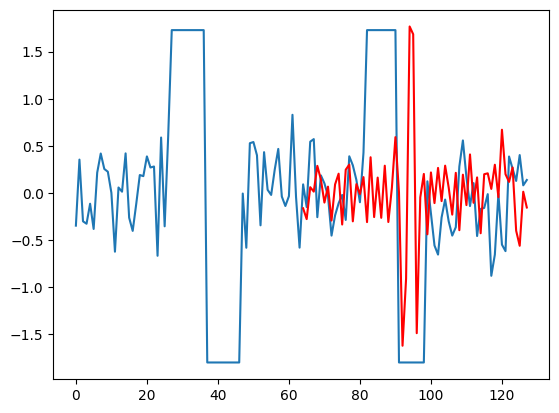

In [15]:
import numpy as np
ts_index = 50

y_pred = model_sdtw(X_test_past).detach().numpy()

plt.figure()
plt.plot(X_test[ts_index])
plt.plot(np.arange(64, 128), y_pred[ts_index], 'r-')
plt.show()

Here, we have compared two models with the same (LSTM-based) architecture. The only difference lies in the loss used to train the model. It seems that the Soft-DTW loss leads to slightly better results in terms of reconstruction, even though the quality is still questionnable.